In [1]:
import cv2,os
data_path='dataset'

 
categories=os.listdir(data_path)  #All Sub Folders present in the dataset folder
labels=[i for i in range(len(categories))]  #Since only 2 folders(without and with mask), lets label them accordingly as 0,1

label_dict=dict(zip(categories,labels)) #dictionary for the labels and respective sub folders

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
#Since there are many images with different colours, orientations..Colour is not an important feature to detect masks, 
#Therefore, we turn all the images to grayscale images

img_size=100  #Resizing the images
data=[]    #List for saving all the grayscale resized images
target=[]  #List for saving the lables


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)  #List for the images of the particular subfolder
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100X100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [3]:
! pip install keras

In [4]:
! pip install tensorflow

  Stored in directory: C:\Users\viswa janith\AppData\Local\pip\Cache\wheels\8e\28\49\fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Stored in directory: C:\Users\viswa janith\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built absl-py termcolor
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0


In [5]:
import numpy as np

data=np.array(data)/255.0    #Converts the pixel range of images to 0 and 1
data=np.reshape(data,(data.shape[0],img_size,img_size,1))  #Converting it into a 4D array as cnn needs a 4D array..
                                                           #1 is there bcoz its a grayscale img.
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)  # Converting into categorical array sice the ouput layer neurons in the DL 
                                            #model will have categorical wise only (with mas and without mask)

In [6]:
np.save('data',data)
np.save('target',new_target)

In [7]:
data=np.load('data.npy')
target=np.load('target.npy')


In [9]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))  #200 kernels of size 3x3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))  #100 kernels of size 3x3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))   #Dropout layer to avoid overfitting
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 50 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [11]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.5424WARNING:tensorflow:From C:\Users\Public\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model\assets
31/31 [==============================] - 36s 1s/step - loss: 0.7326 - accuracy: 0.5424 - val_loss: 0.6267 - val_accuracy: 0.6613
Epoch 2/20
31/31 [==============================] - 38s 1s/step - loss: 0.5737 - accuracy: 0.7212 - val_loss: 0.4166 - val_accuracy: 0.8306
Epoch 3/20
31/31 [==============================] - 39s 1s/step - loss: 0.3705 - accuracy: 0.8293 - val

<Figure size 640x480 with 1 Axes>

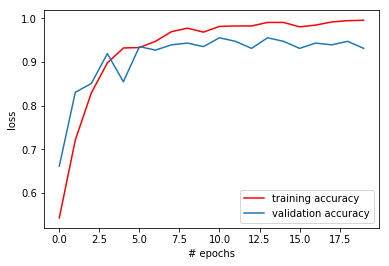

5/5 [==============================] - 1s 176ms/step - loss: 0.1003 - accuracy: 0.9710
[0.1002839133143425, 0.9710144996643066]


In [12]:

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
print(model.evaluate(test_data,test_target))

In [13]:
from keras.models import load_model

In [19]:
new=test_data[:5]
y_PRED=model.predict_classes(new)

In [20]:
print(y_PRED)

[1 0 1 0 0]


AxesImage(54,36;334.8x217.44)


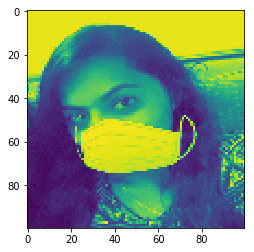

In [21]:
print(plt.imshow(test_data[2].reshape(100,100)))

AxesImage(54,36;334.8x217.44)


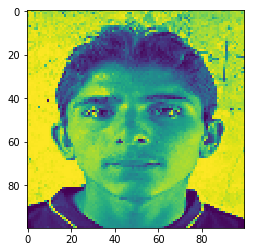

In [22]:
print(plt.imshow(test_data[3].reshape(100,100)))